# RTP Forecasting

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import keras
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
print(tf.__version__)

2.12.0


In [3]:
cwd = os.getcwd()

In [4]:
def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)

In [5]:
#timing callback
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [6]:
# Plot history and future
def plot_predictions(pred, actual, title):
    plt.figure(figsize=(20, 4), dpi=150)
    plt.plot(np.arange(len(pred)), np.array(pred),label='LSTM',alpha=0.7)
    plt.plot(np.arange(len(pred)), np.array(actual),label='PF', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='--', lw=1, alpha=0.5)
    plt.legend(loc='upper right')
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('Price' , fontsize=18)
    plt.title(title, fontsize=16)

In [8]:
# Plot history and future
def plot_predictions_slide(pred_1,pred_2,pred_3, actual, title):
    plt.figure(figsize=(20, 4), dpi=150)
    plt.plot(np.arange(len(pred_1)), np.array(actual),label='PF', alpha=0.7)
    plt.plot(np.arange(len(pred_1)), np.array(pred_1),label='LSTM-24',alpha=0.7)
    plt.plot(np.arange(len(pred_1)), np.array(pred_2),label='LSTM-48',alpha=0.7)
    plt.plot(np.arange(len(pred_1)), np.array(pred_3),label='LSTM-27',alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='--', lw=1, alpha=0.5)
    plt.legend(loc='upper right')
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('Price' , fontsize=18)
    plt.title(title, fontsize=16)

In [7]:
# Plot history and future
def plot_predictions_models(pred_1,pred_2,pred_3, actual, title):
    plt.figure(figsize=(20, 4), dpi=150)
    plt.plot(np.arange(len(pred_1)), np.array(actual),label='PF', alpha=0.7)
    plt.plot(np.arange(len(pred_1)), np.array(pred_1),label='LSTM',alpha=0.7)
    plt.plot(np.arange(len(pred_1)), np.array(pred_2),label='CNN',alpha=0.7)
    plt.plot(np.arange(len(pred_1)), np.array(pred_3),label='CNN-LSTM',alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='--', lw=1, alpha=0.5)
    plt.legend(loc='upper right')
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('Price' , fontsize=18)
    plt.title(title, fontsize=16)

In [9]:
#zones = ['CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'HUD VL', 'LONGIL',
#         'MHK VL', 'MILLWD', 'N.Y.C.', 'NORTH', 'WEST']
zone = 'N.Y.C.'
year = 2021

### Data Import

In [10]:
# Read each timeseries (RTP = Real-Time Price, DAP = Day-Ahead Price, LF = Load Forecast)
raw_DAP = pd.read_csv("nyiso/da_lmp_zones_df_2015_2021.csv", index_col=0)
raw_RTP = pd.read_csv("nyiso/rt_lmp_zones_df_2015_2021.csv", index_col=0)
raw_LF = pd.read_csv("nyiso/load_frcstd_df_2015_2021.csv", index_col=0)

In [11]:
# Prepare the dataset as a dataframe
raw_data = pd.concat([raw_DAP.loc[:,zone], raw_LF.loc[:,zone], raw_RTP.loc[:,zone]],
                       axis=1).loc['2017-01-01 05:00:00+00:00':]
raw_data.columns = ['DAP', 'LF', 'RTP']
raw_data.index.names = ['date']
raw_data.to_csv('nyiso/NYISO_'+zone+'_raw.csv')

In [12]:
raw_data

,DAP,LF,RTP
date,,,
2017-01-01 05:00:00+00:00,33.60,5065,32.28
2017-01-01 06:00:00+00:00,32.05,4934,30.77
2017-01-01 07:00:00+00:00,29.23,4812,31.17
2017-01-01 08:00:00+00:00,25.02,4728,32.00
2017-01-01 09:00:00+00:00,26.94,4665,27.89
...,...,...,...
2022-01-01 00:00:00+00:00,33.49,5362,30.21
2022-01-01 01:00:00+00:00,31.28,5139,30.23
2022-01-01 02:00:00+00:00,30.49,4943,30.34


In [13]:
# We perform log tranformation before feeding the dataset into the model to make enhance the performance
# We only log tranform the price data (RTP and DAP)
log = 1
# log transformation for the forecasting task log10(Y + 1 - min(Y))
if log:
    log_data = raw_data.copy(deep=True)
    log_data.loc[:,"DAP"] = np.log(raw_data.loc[:,"DAP"] + 1 - min(raw_data.loc[:,"DAP"]))
    log_data.loc[:,"RTP"] = np.log(raw_data.loc[:,"RTP"] + 1 - min(raw_data.loc[:,"RTP"]))
    log_data.to_csv('nyiso/NYISO_'+zone+'_log.csv')

In [14]:
log_data

,DAP,LF,RTP
date,,,
2017-01-01 05:00:00+00:00,3.361417,5065,5.143475
2017-01-01 06:00:00+00:00,3.306154,4934,5.134621
2017-01-01 07:00:00+00:00,3.197039,4812,5.136974
2017-01-01 08:00:00+00:00,3.008155,4728,5.141839
2017-01-01 09:00:00+00:00,3.098740,4665,5.117515
...,...,...,...
2022-01-01 00:00:00+00:00,3.357594,5362,5.131318
2022-01-01 01:00:00+00:00,3.277522,5139,5.131436
2022-01-01 02:00:00+00:00,3.247269,4943,5.132086


### Data Preprocessing

In [15]:
# Split dataset: 2015 year for training and 2016-2017 years for testing
x_train_df = log_data.iloc[:8760*4+24,:]
x_test_df = log_data.iloc[8760*4+24:,:]

y_train_df = log_data.iloc[:8760*4+24,2:]
y_test_df = log_data.iloc[8760*4+24:,2:]

In [16]:
# Standardization
x_mean, x_std = x_train_df.mean(), x_train_df.std()
y_mean, y_std = y_train_df.mean(), y_train_df.std()

x_train = ((x_train_df - x_mean)/x_std).to_numpy()
x_test = ((x_test_df - x_mean)/x_std).to_numpy()

y_train = ((y_train_df - y_mean)/y_std).to_numpy()
y_test = ((y_test_df - y_mean)/y_std).to_numpy()

print(x_train.shape,y_train.shape,x_test.shape, y_test.shape)

(35064, 3) (35064, 1) (8760, 3) (8760, 1)


# Deciding the best model
comparing all the models (CNN, CNN-LSTM). 

### lag 24

In [19]:
n_steps_in = 24
n_steps_out = 24
x_test_lstm = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_lstm_24 = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])

model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

lstm_model = load_model(os.path.join(model_path,'LSTM_model_best_24h.h5'))
y_test_pred_lstm_24 = lstm_model.predict(x_test_lstm)
cnn_model = load_model(os.path.join(model_path,'CNN_model_best_24h.h5'))
y_test_pred_cnn_24 = cnn_model.predict(x_test_lstm)
cnn_lstm_model = load_model(os.path.join(model_path,'CNN_LSTM_model_best_24h.h5'))
y_test_pred_cnn_lstm_24 = cnn_lstm_model.predict(x_test_lstm)

273/273 [==============================] - 1s 1ms/step


In [22]:
y_test_pred_lstm_rescale_24 = y_test_pred_lstm_24*y_std.values + y_mean.values
y_test_lstm_rescale_24 = y_test_lstm_24*y_std.values + y_mean.values
y_test_pred_lstm_invlog_24 = np.exp(y_test_pred_lstm_rescale_24) -1 + min(raw_data.loc[:,"RTP"])
y_test_lstm_invlog_24 = np.exp(y_test_lstm_rescale_24) -1 + min(raw_data.loc[:,"RTP"])

y_test_pred_cnn_rescale_24 = y_test_pred_cnn_24*y_std.values + y_mean.values
y_test_pred_cnn_invlog_24 = np.exp(y_test_pred_cnn_rescale_24) -1 + min(raw_data.loc[:,"RTP"])

y_test_pred_cnn_lstm_rescale_24 = y_test_pred_cnn_lstm_24*y_std.values + y_mean.values
y_test_pred_cnn_lstm_invlog_24 = np.exp(y_test_pred_cnn_lstm_rescale_24) -1 + min(raw_data.loc[:,"RTP"])

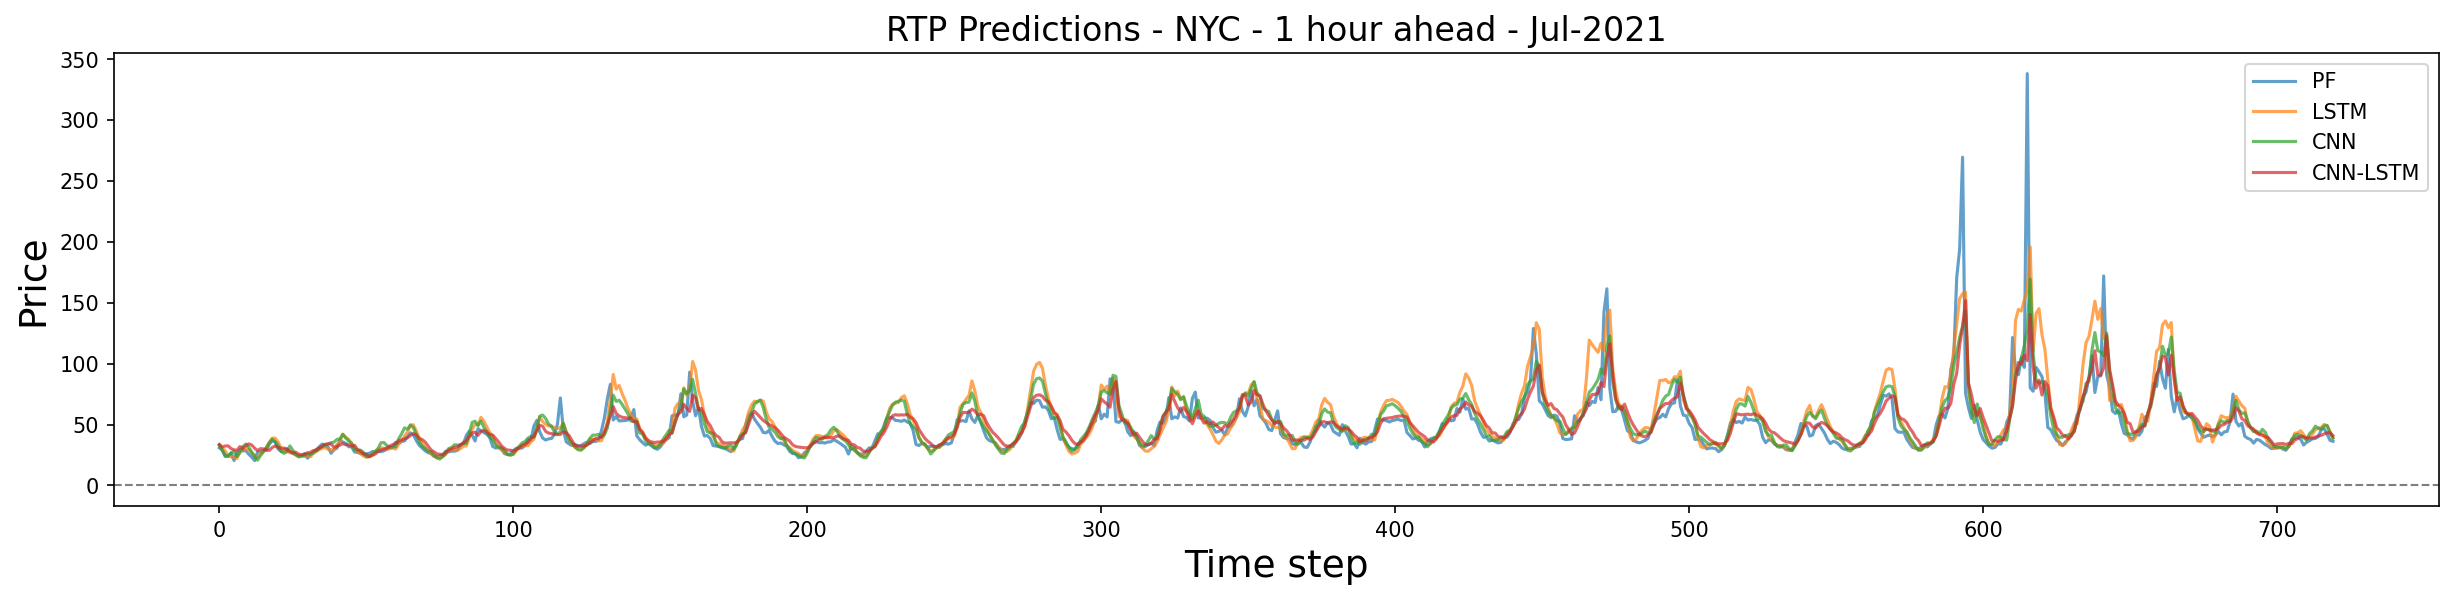

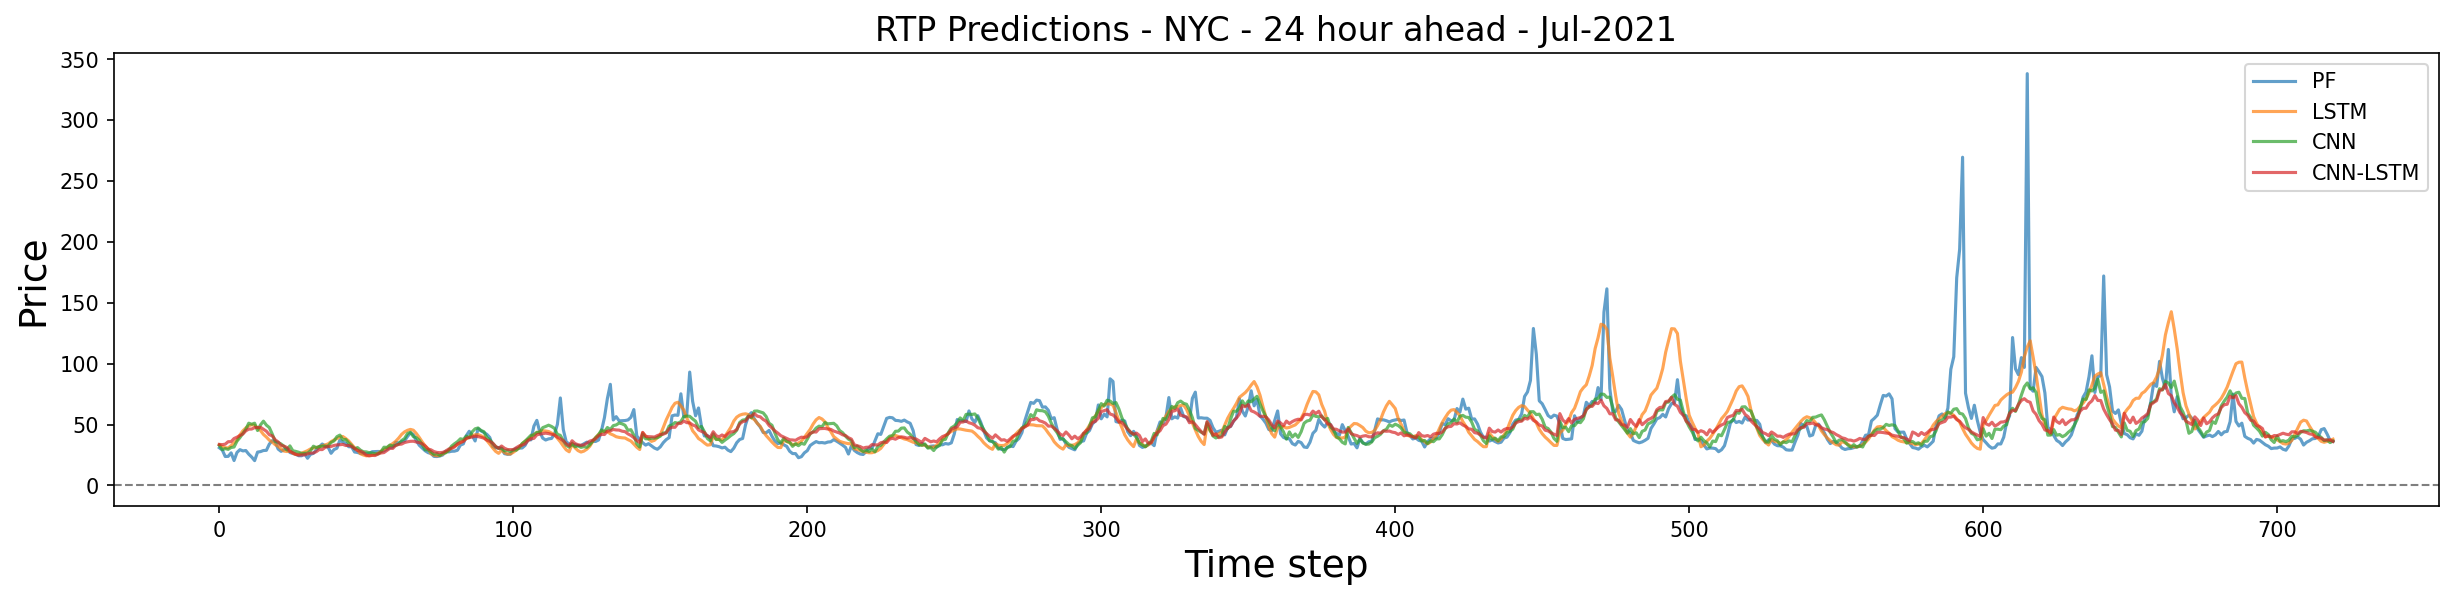

In [24]:
i = 7*24*30
j = i + 24*30

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j,0].flatten(),
                       y_test_lstm_invlog_24[i:j,0,0].flatten(),
                       'RTP Predictions - NYC - 1 hour ahead - Jul-2021')

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_lstm_invlog_24[i:j:24,:].flatten(),
                       'RTP Predictions - NYC - 24 hour ahead - Jul-2021')

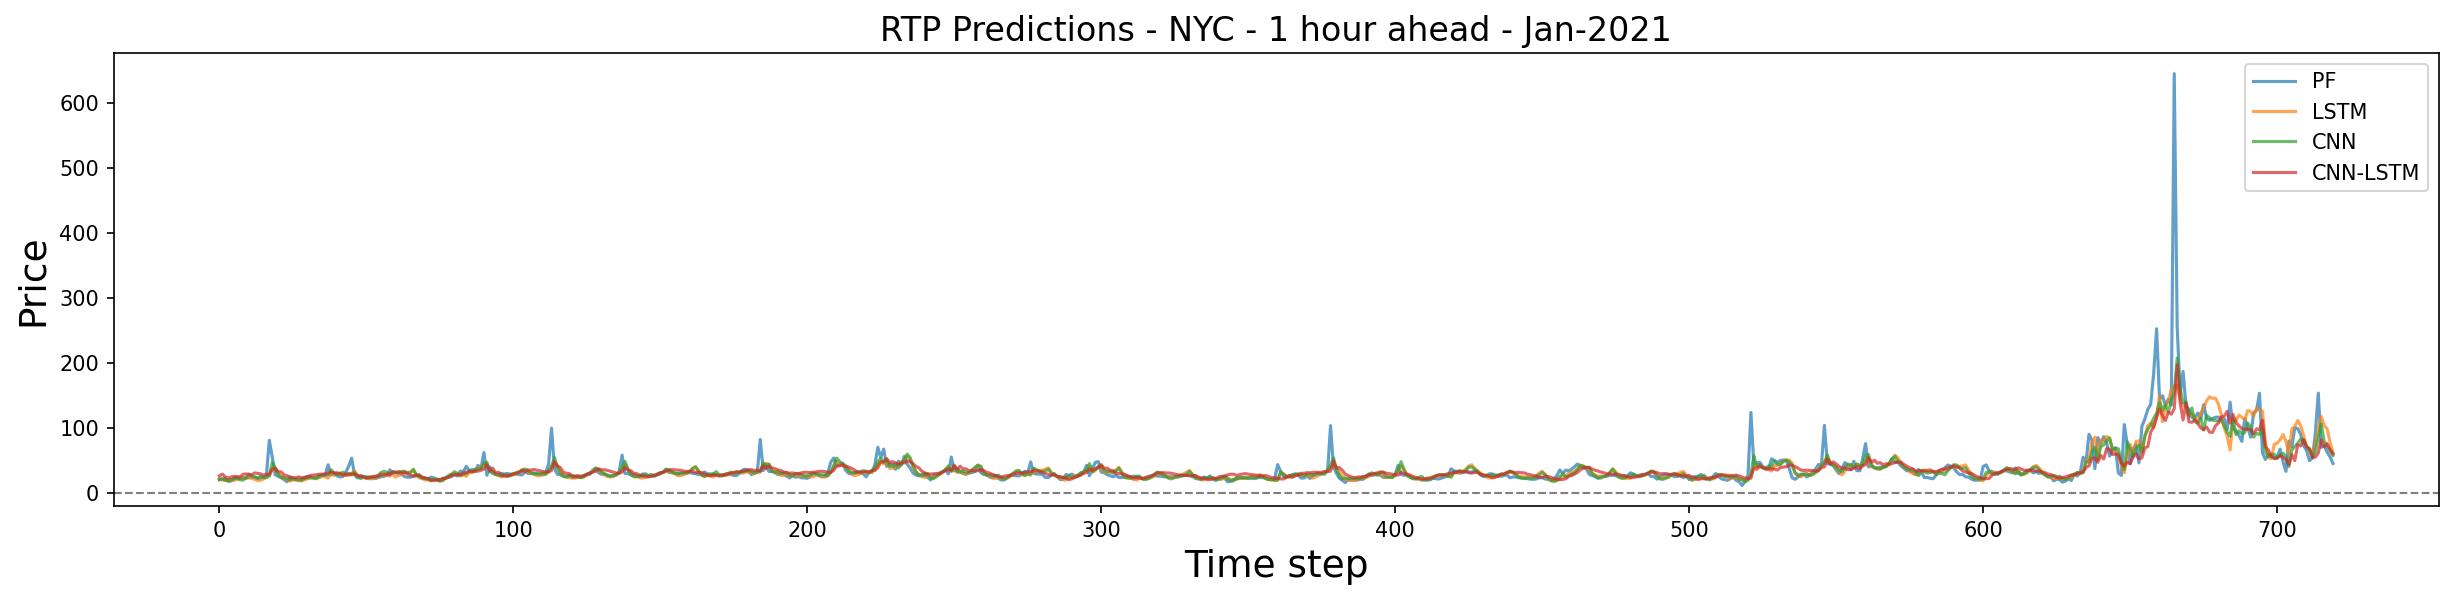

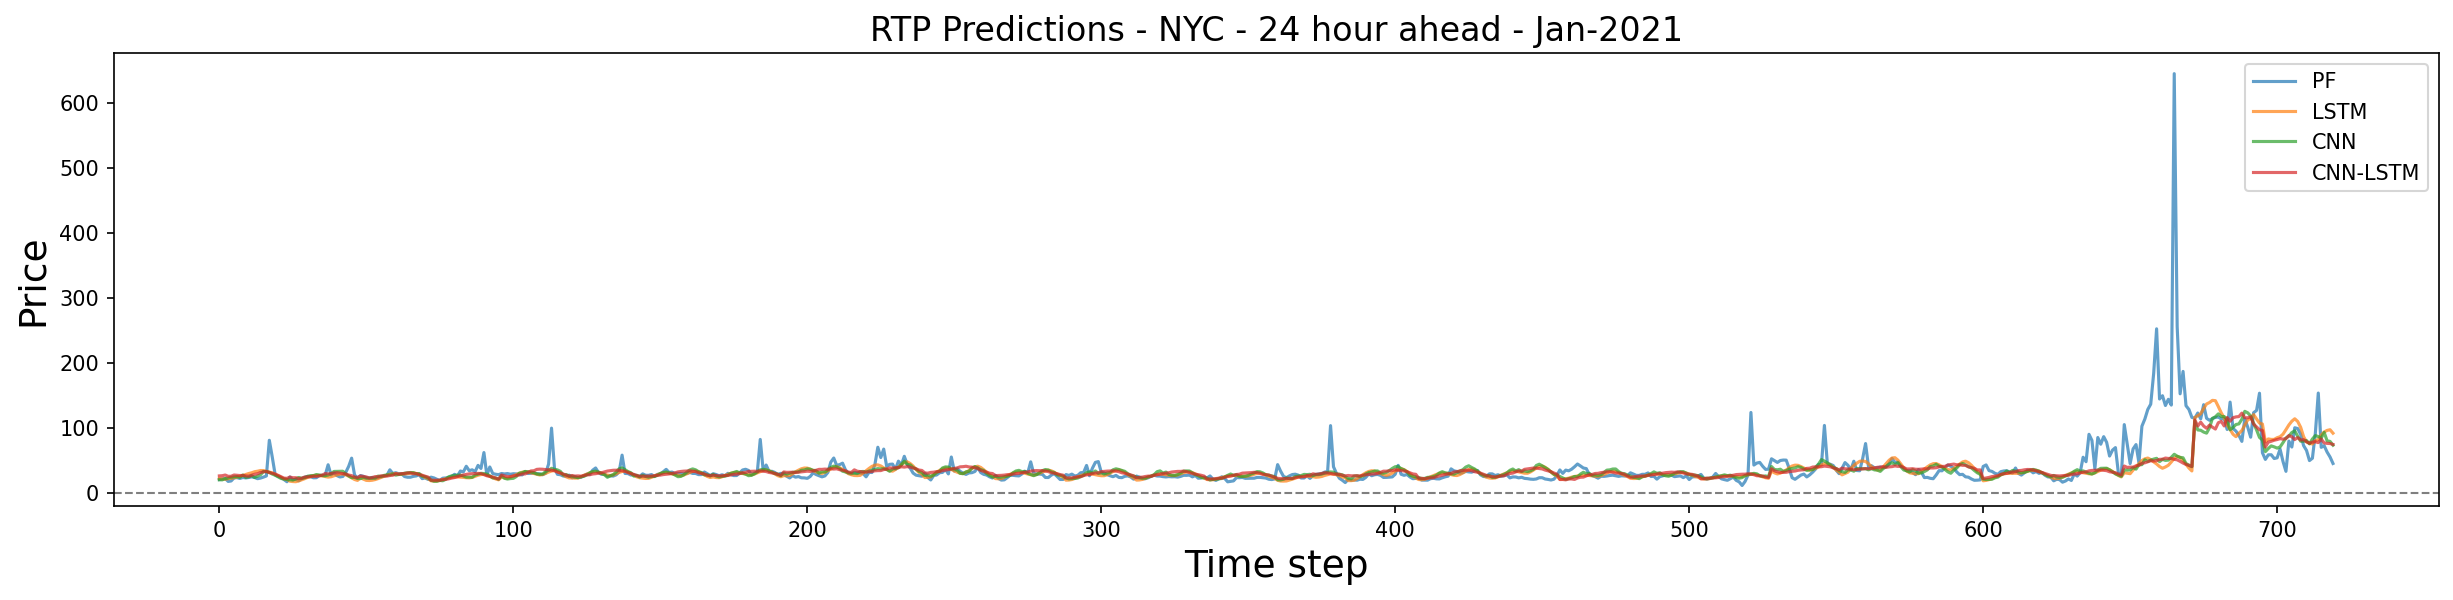

In [25]:
i = 0*24*30
j = i + 24*30

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j,0].flatten(),
                       y_test_lstm_invlog_24[i:j,0,0].flatten(),
                       'RTP Predictions - NYC - 1 hour ahead - Jan-2021')

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_lstm_invlog_24[i:j:24,:].flatten(),
                       'RTP Predictions - NYC - 24 hour ahead - Jan-2021')

### lag 48

In [26]:
n_steps_in = 48
n_steps_out = 24
x_test_lstm = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_lstm_24 = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])

model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

lstm_model = load_model(os.path.join(model_path,'LSTM_model_best_48h.h5'))
y_test_pred_lstm_24 = lstm_model.predict(x_test_lstm)
cnn_model = load_model(os.path.join(model_path,'CNN_model_best_48h.h5'))
y_test_pred_cnn_24 = cnn_model.predict(x_test_lstm)
cnn_lstm_model = load_model(os.path.join(model_path,'CNN_LSTM_model_best_48h.h5'))
y_test_pred_cnn_lstm_24 = cnn_lstm_model.predict(x_test_lstm)

272/272 [==============================] - 1s 2ms/step


In [27]:
y_test_pred_lstm_rescale_24 = y_test_pred_lstm_24*y_std.values + y_mean.values
y_test_lstm_rescale_24 = y_test_lstm_24*y_std.values + y_mean.values
y_test_pred_lstm_invlog_24 = np.exp(y_test_pred_lstm_rescale_24) -1 + min(raw_data.loc[:,"RTP"])
y_test_lstm_invlog_24 = np.exp(y_test_lstm_rescale_24) -1 + min(raw_data.loc[:,"RTP"])

y_test_pred_cnn_rescale_24 = y_test_pred_cnn_24*y_std.values + y_mean.values
y_test_pred_cnn_invlog_24 = np.exp(y_test_pred_cnn_rescale_24) -1 + min(raw_data.loc[:,"RTP"])

y_test_pred_cnn_lstm_rescale_24 = y_test_pred_cnn_lstm_24*y_std.values + y_mean.values
y_test_pred_cnn_lstm_invlog_24 = np.exp(y_test_pred_cnn_lstm_rescale_24) -1 + min(raw_data.loc[:,"RTP"])

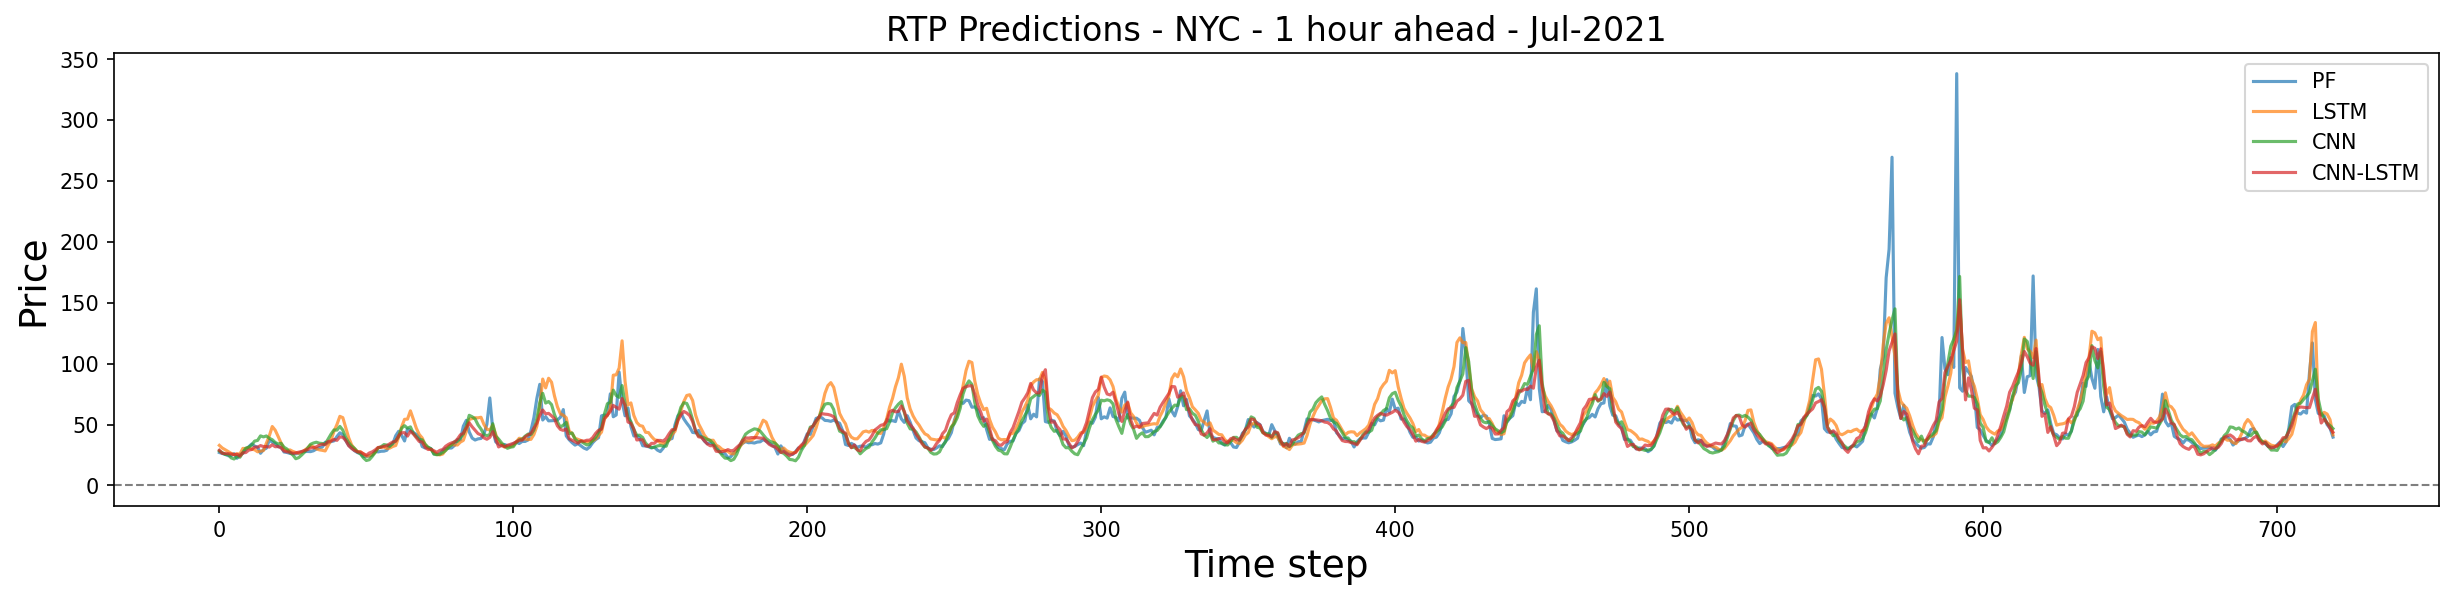

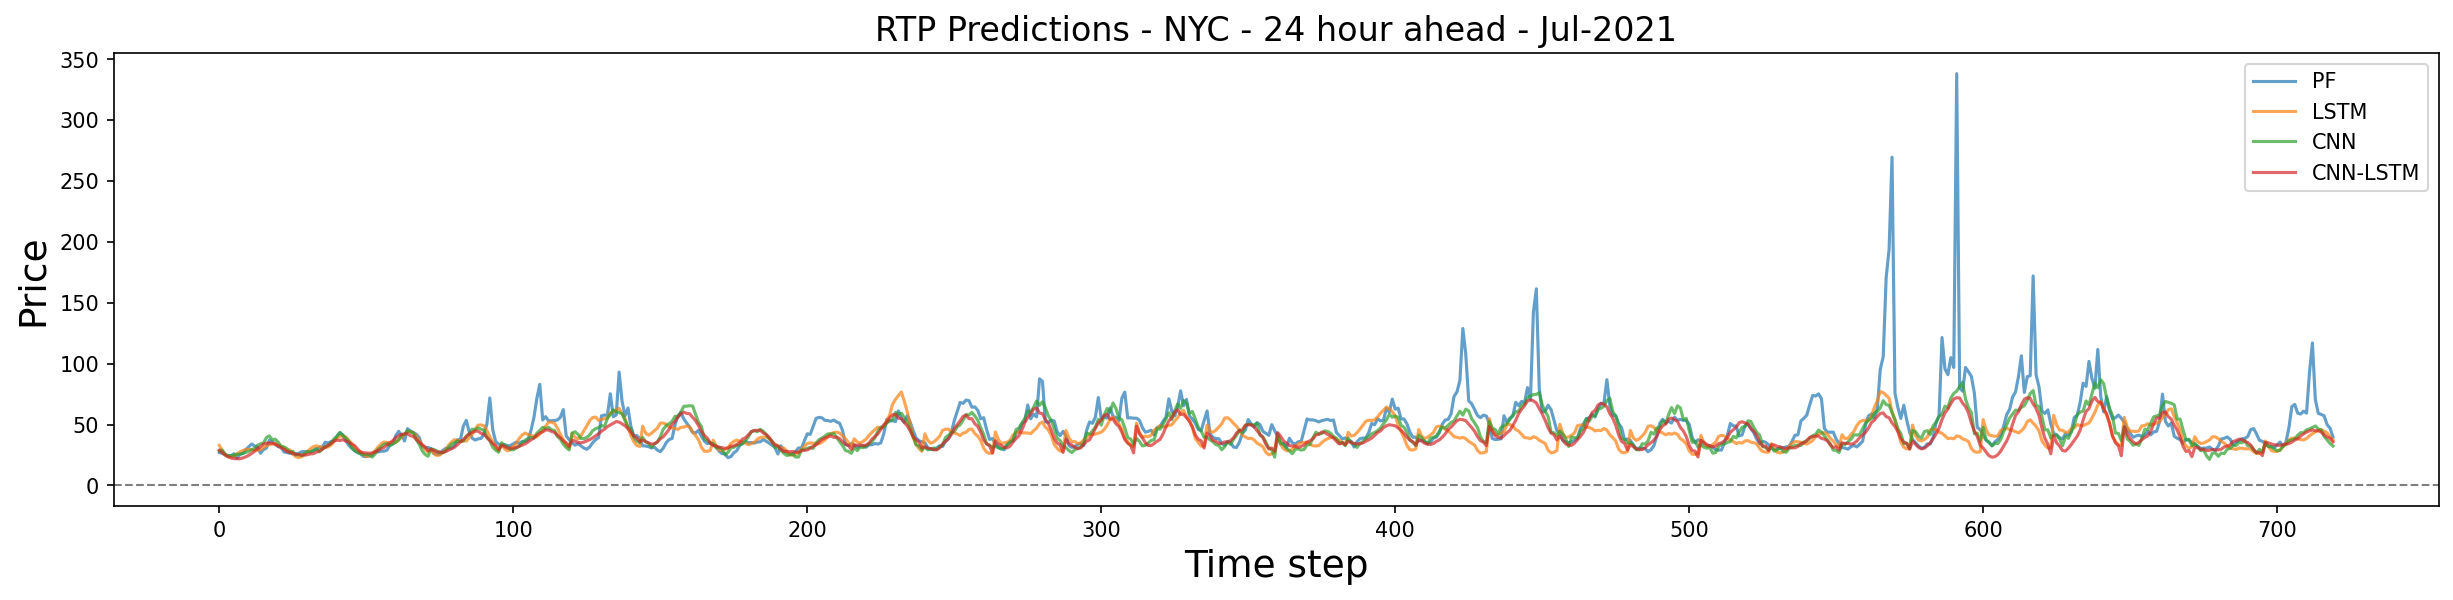

In [28]:
i = 7*24*30
j = i + 24*30

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j,0].flatten(),
                       y_test_lstm_invlog_24[i:j,0,0].flatten(),
                       'RTP Predictions - NYC - 1 hour ahead - Jul-2021')

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_lstm_invlog_24[i:j:24,:].flatten(),
                       'RTP Predictions - NYC - 24 hour ahead - Jul-2021')

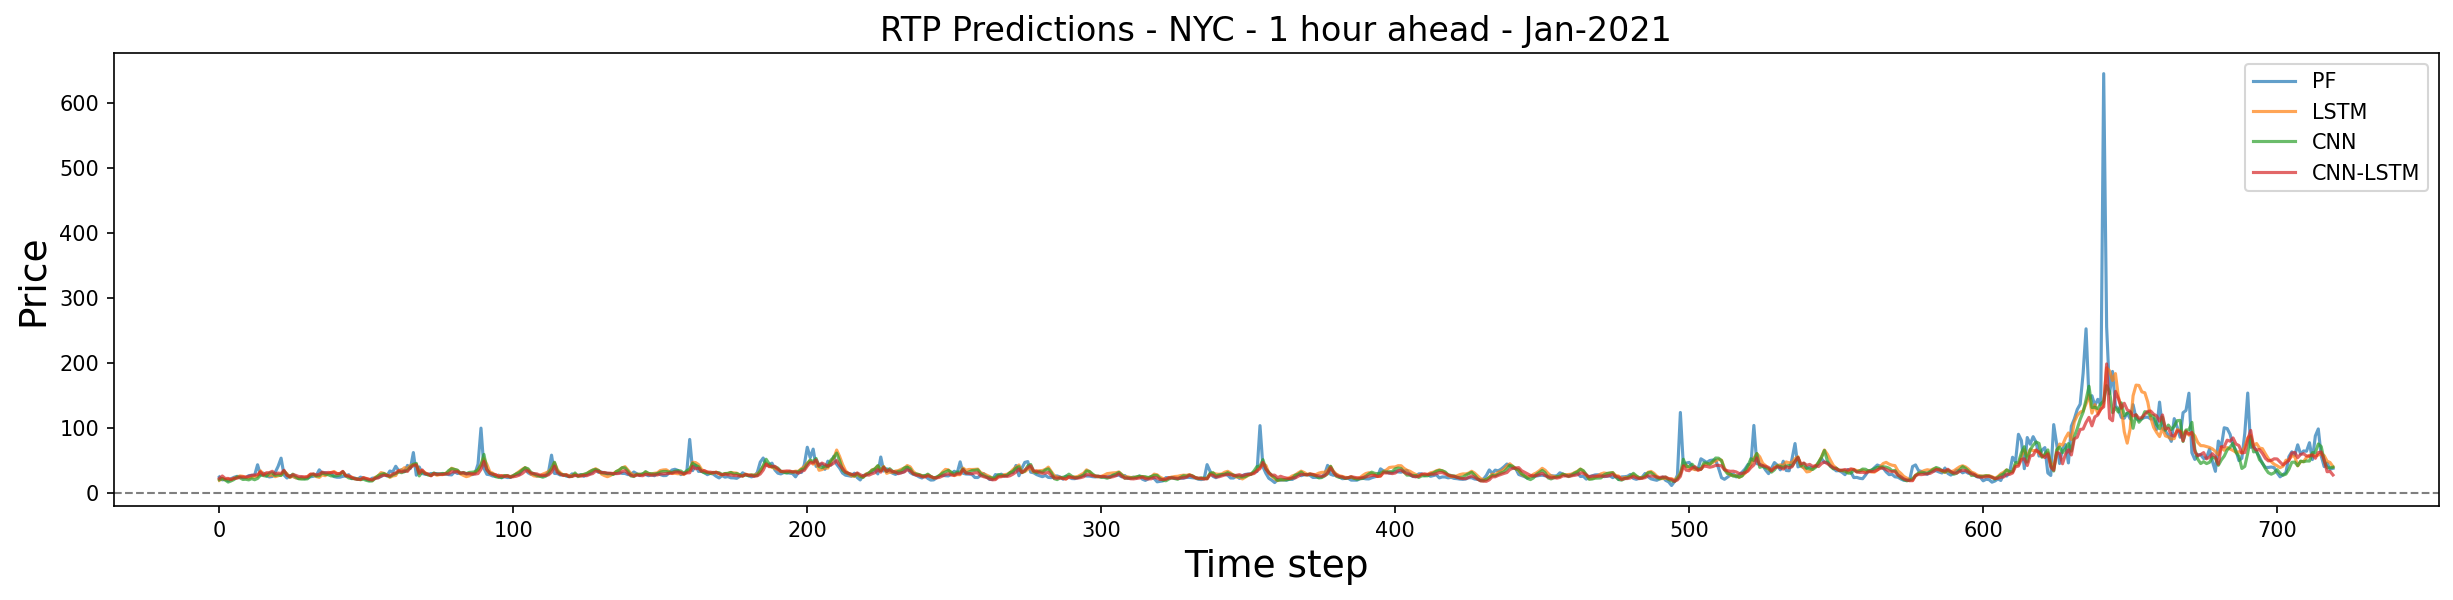

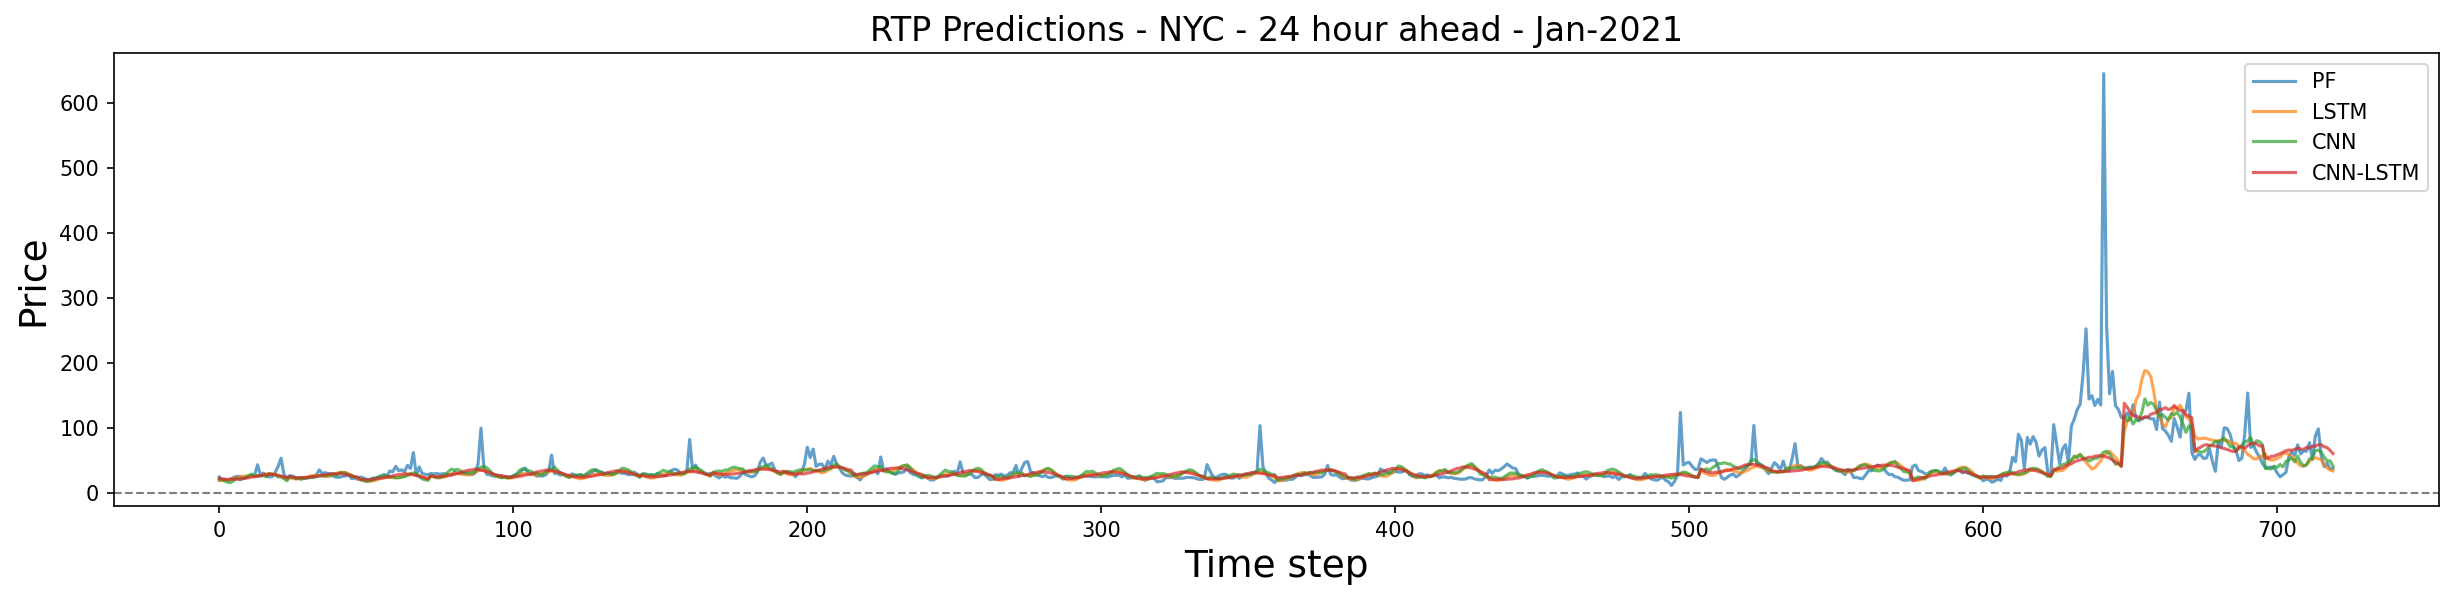

In [29]:
i = 0*24*30
j = i + 24*30

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j,0].flatten(),
                       y_test_lstm_invlog_24[i:j,0,0].flatten(),
                       'RTP Predictions - NYC - 1 hour ahead - Jan-2021')

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_lstm_invlog_24[i:j:24,:].flatten(),
                       'RTP Predictions - NYC - 24 hour ahead - Jan-2021')

### lag 72

In [30]:
n_steps_in = 72
n_steps_out = 24
x_test_lstm = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_lstm_24 = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])

model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

lstm_model = load_model(os.path.join(model_path,'LSTM_model_best_72h.h5'))
y_test_pred_lstm_24 = lstm_model.predict(x_test_lstm)
cnn_model = load_model(os.path.join(model_path,'CNN_model_best_72h.h5'))
y_test_pred_cnn_24 = cnn_model.predict(x_test_lstm)
cnn_lstm_model = load_model(os.path.join(model_path,'CNN_LSTM_model_best_72h.h5'))
y_test_pred_cnn_lstm_24 = cnn_lstm_model.predict(x_test_lstm)

271/271 [==============================] - 1s 2ms/step


In [31]:
y_test_pred_lstm_rescale_24 = y_test_pred_lstm_24*y_std.values + y_mean.values
y_test_lstm_rescale_24 = y_test_lstm_24*y_std.values + y_mean.values
y_test_pred_lstm_invlog_24 = np.exp(y_test_pred_lstm_rescale_24) -1 + min(raw_data.loc[:,"RTP"])
y_test_lstm_invlog_24 = np.exp(y_test_lstm_rescale_24) -1 + min(raw_data.loc[:,"RTP"])

y_test_pred_cnn_rescale_24 = y_test_pred_cnn_24*y_std.values + y_mean.values
y_test_pred_cnn_invlog_24 = np.exp(y_test_pred_cnn_rescale_24) -1 + min(raw_data.loc[:,"RTP"])

y_test_pred_cnn_lstm_rescale_24 = y_test_pred_cnn_lstm_24*y_std.values + y_mean.values
y_test_pred_cnn_lstm_invlog_24 = np.exp(y_test_pred_cnn_lstm_rescale_24) -1 + min(raw_data.loc[:,"RTP"])

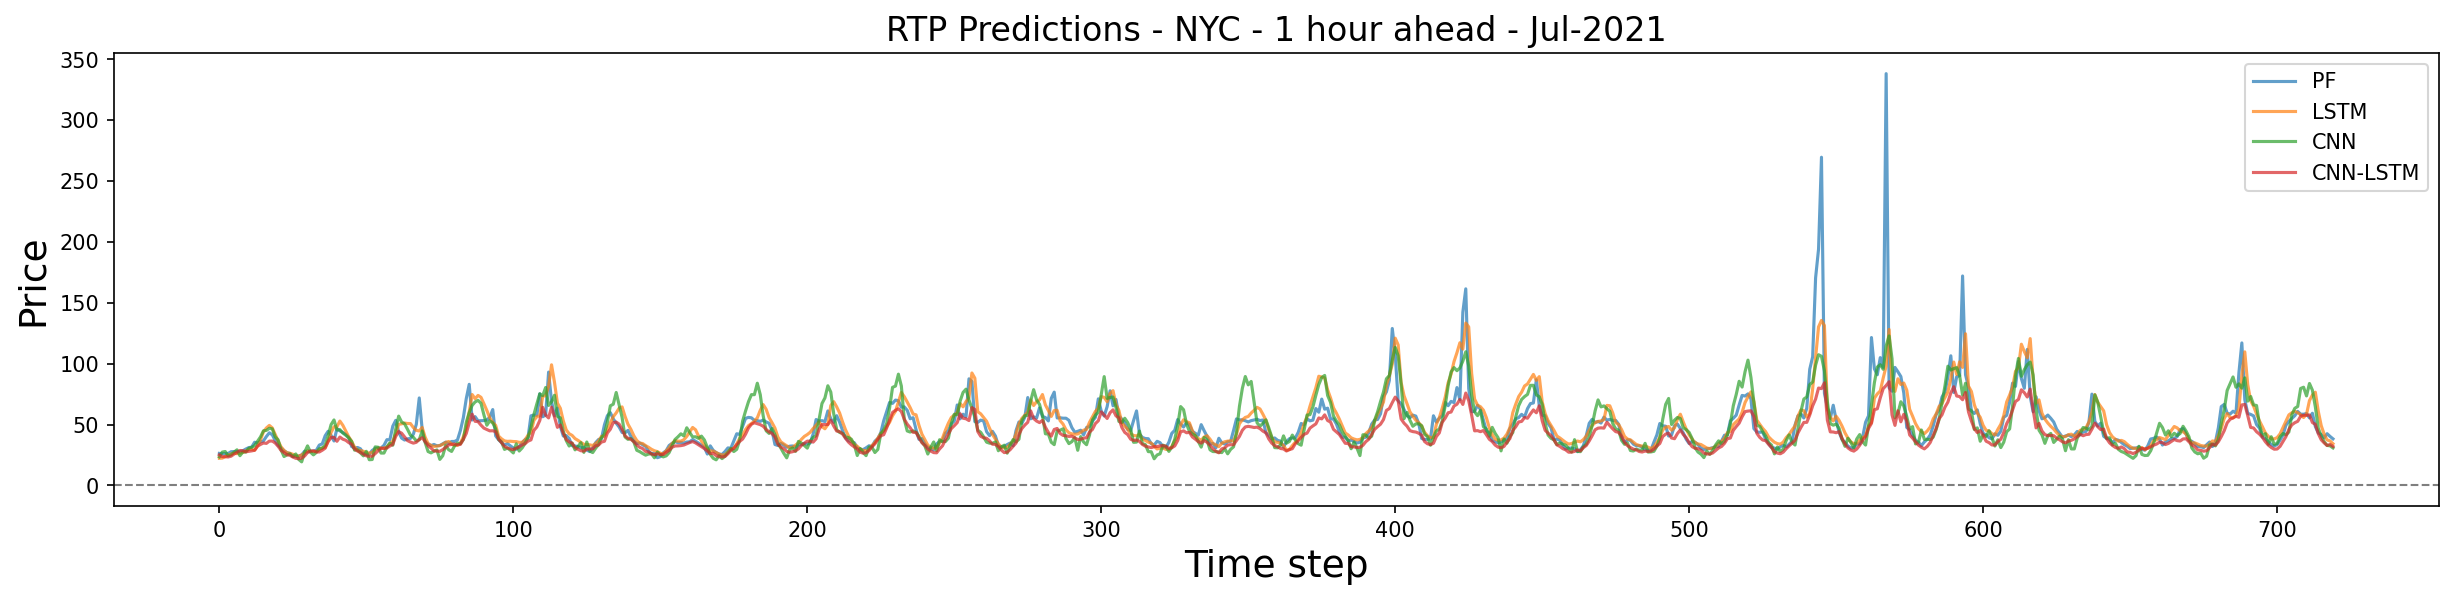

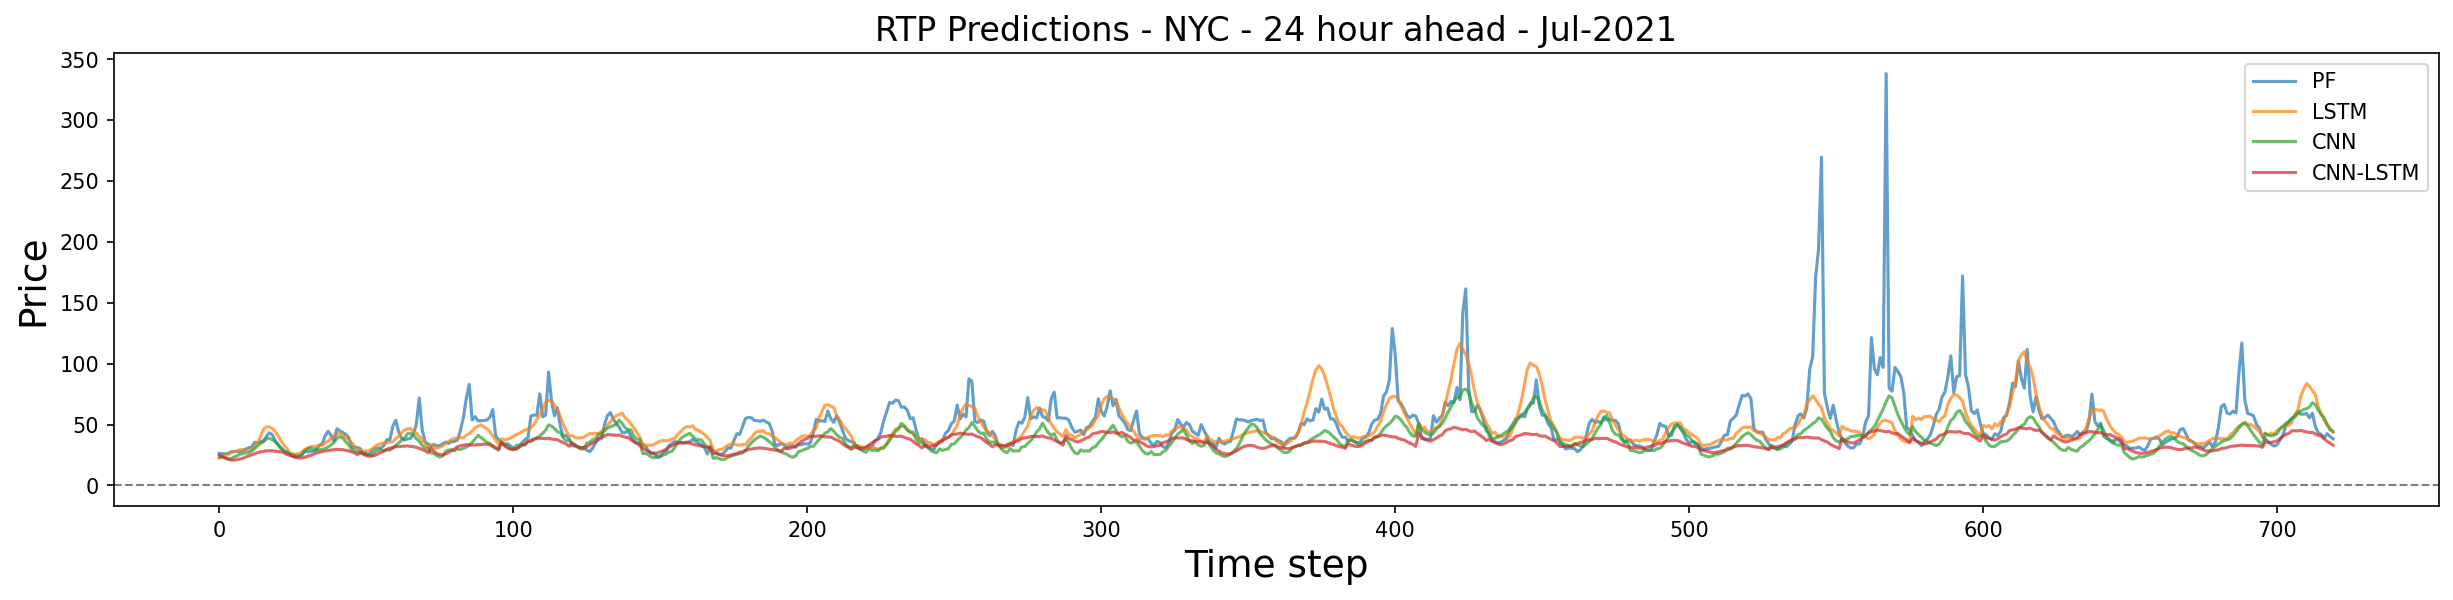

In [32]:
i = 7*24*30
j = i + 24*30

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j,0].flatten(),
                       y_test_lstm_invlog_24[i:j,0,0].flatten(),
                       'RTP Predictions - NYC - 1 hour ahead - Jul-2021')

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_lstm_invlog_24[i:j:24,:].flatten(),
                       'RTP Predictions - NYC - 24 hour ahead - Jul-2021')

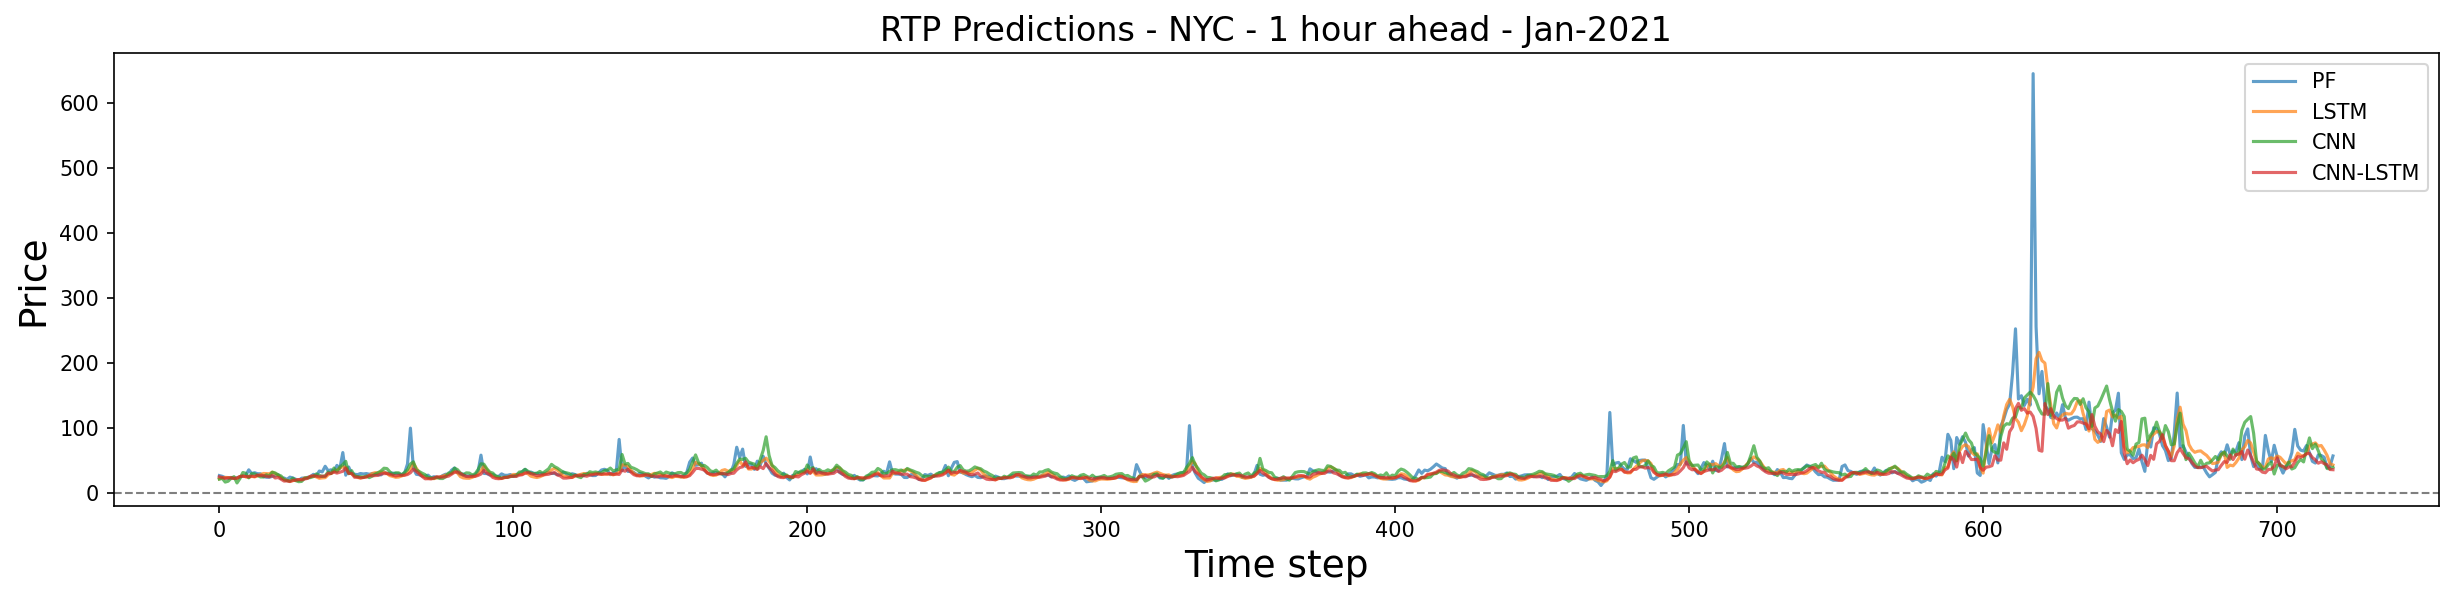

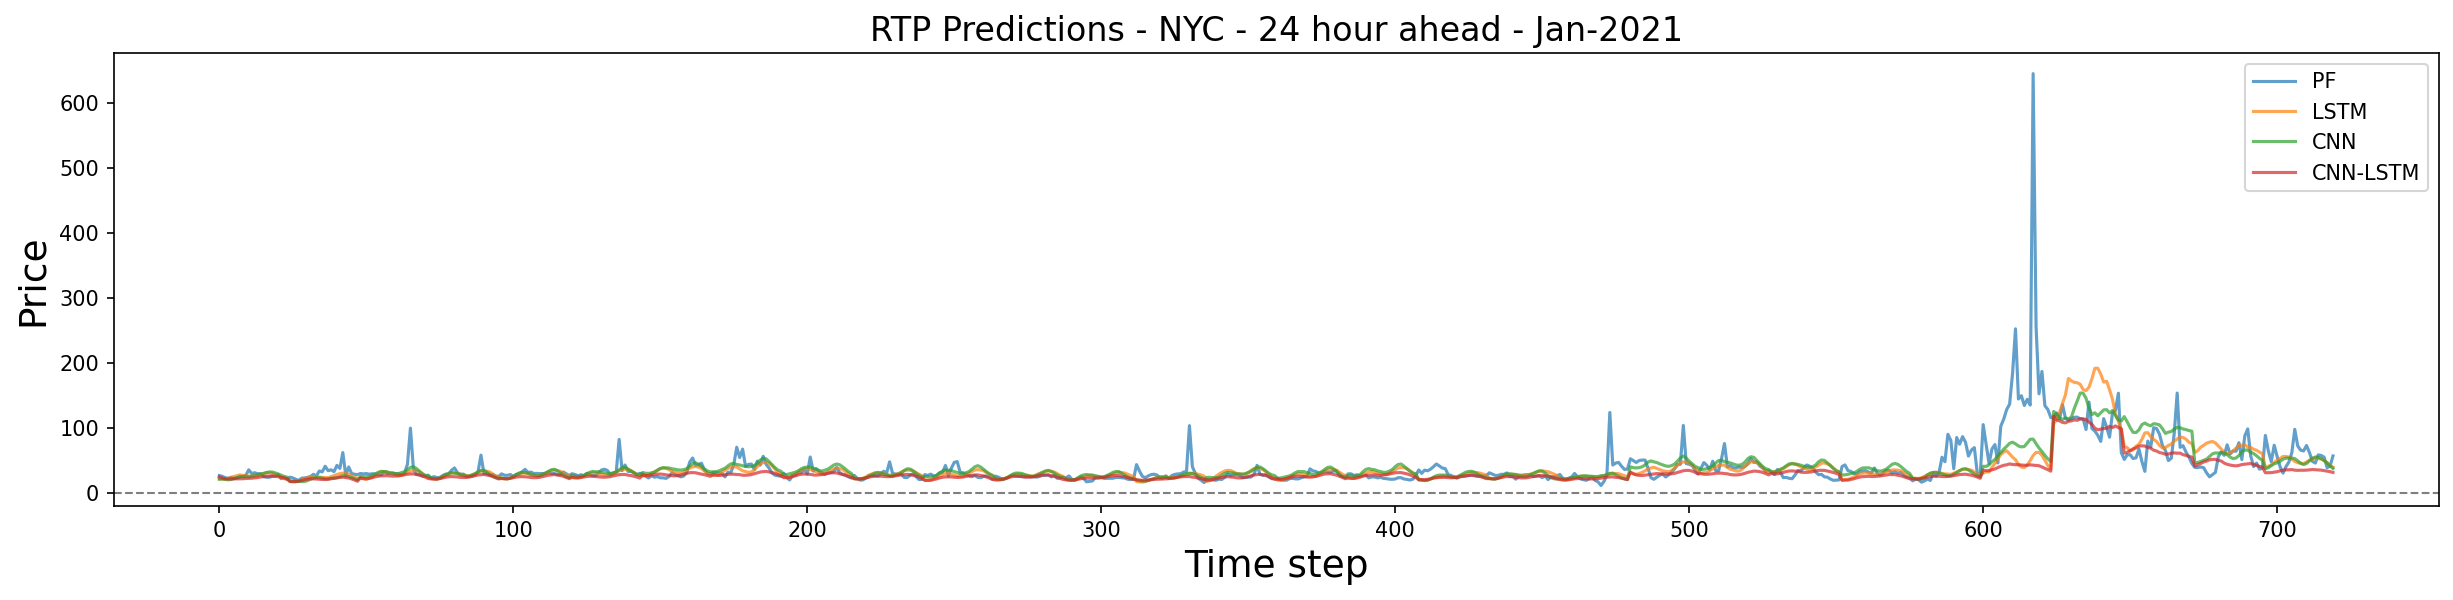

In [33]:
i = 0*24*30
j = i + 24*30

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j,0].flatten(),
                       y_test_lstm_invlog_24[i:j,0,0].flatten(),
                       'RTP Predictions - NYC - 1 hour ahead - Jan-2021')

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_lstm_invlog_24[i:j:24,:].flatten(),
                       'RTP Predictions - NYC - 24 hour ahead - Jan-2021')